In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model

# Dataset

In [34]:
!pwd

/mnt/batch/tasks/shared/LS_root/mounts/clusters/mini-project/code/Users/1032190116


## Data visualization

Normal chest x-ray


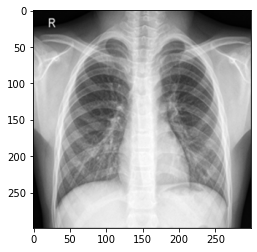

Covid chest x-ray


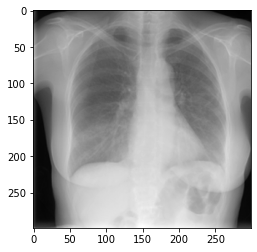

Viral Pneumonia chest x-ray


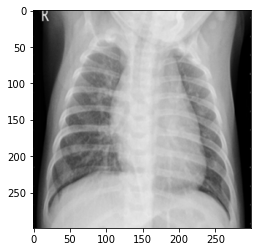

In [2]:
img_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mini-project/code/Users/1032190116/COVID-19_Radiography_Dataset/COVID/'
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Normal')
pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')

print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Normal',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Covid chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Viral Pneumonia chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()


## Image pre-processing and train-test split

In [3]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [4]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,21165,21165
unique,21165,4
top,Lung_Opacity/Lung_Opacity-4101.png,Normal
freq,1,10192


In [5]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  total = len(df.index)
  freq_r = freq_a[0]/total
  freq_a[1] = freq_r
  freq_a.columns = ['Label','Frequência absoluta','Frequência relativa']
  return freq_a
frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,Normal,10192,0.481550
1,Lung_Opacity,6012,0.284054
2,Viral Pneumonia,1345,0.063548
3,COVID,3616,0.170848


## Undersampling classes

The dataset is unbalanced. As our focus is the COVID class, we will undersample classes with more examples than the COVID class and keep classes with less examples.

In [6]:
def balance_dataset(focus_class, df):
  classes = df.label.unique()
  classes_df_list = []
  focus_class_df = df[df.label == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  ##Divide by class
  for classe in classes:
    class_df = df[df.label == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class+1000:
      class_df = class_df.sample(count_focus_class+1000)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('COVID',df)

frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,COVID,3616,0.254773
1,Normal,4616,0.325231
2,Lung_Opacity,4616,0.325231
3,Viral Pneumonia,1345,0.094765


In [7]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
# traindf = balance_dataset('COVID',df)


traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [8]:
frequency_plot(traindf)

,Label,Frequência absoluta,Frequência relativa
0,COVID,2712,0.254791
1,Lung_Opacity,3462,0.325254
2,Viral Pneumonia,1008,0.094701
3,Normal,3462,0.325254


In [9]:
frequency_plot(valdf)

,Label,Frequência absoluta,Frequência relativa
0,COVID,452,0.254791
1,Lung_Opacity,577,0.325254
2,Viral Pneumonia,168,0.094701
3,Normal,577,0.325254


In [10]:
frequency_plot(testdf)

,Label,Frequência absoluta,Frequência relativa
0,Normal,577,0.325070
1,Lung_Opacity,577,0.325070
2,COVID,452,0.254648
3,Viral Pneumonia,169,0.095211


## Image Data Generator

In [11]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [12]:
BATCH_SIZE=50

"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)


val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=30,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=5,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)




Creating train generator...
Found 10644 validated image filenames belonging to 4 classes.
Found 1775 validated image filenames belonging to 4 classes.

Creating val generator...
Found 1774 validated image filenames belonging to 4 classes.


# Classifier Model

## Importing VGG16 model

In [13]:
from keras.applications.vgg16 import VGG16
base_convnet = VGG16(include_top=False, input_shape=input_shape,
                     weights='imagenet')


#Freeze base convolutional layers
base_convnet.trainable = False
base_convnet.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

## Addition of fully connected layers

In [14]:
model = models.Sequential()
model.add(base_convnet)

# model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(4, activation='softmax',name="fc_out"))

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                 4

## Training the classification model

In [16]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [17]:
EPOCHS = 50
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
    # optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 28s 467ms/step - loss: 1.3522 - recall: 0.1148 - precision: 0.4605 - acc: 0.3441 - val_loss: 0.9462 - val_recall: 0.4040 - val_precision: 0.7537 - val_acc: 0.5600
Epoch 2/50
50/50 [==============================] - 20s 390ms/step - loss: 0.9502 - recall: 0.3761 - precision: 0.7373 - acc: 0.6055 - val_loss: 0.7677 - val_recall: 0.5400 - val_precision: 0.8133 - val_acc: 0.7080
Epoch 3/50
50/50 [==============================] - 17s 341ms/step - loss: 0.7870 - recall: 0.5562 - precision: 0.7929 - acc: 0.7059 - val_loss: 0.6106 - val_recall: 0.7160 - val_precision: 0.8861 - val_acc: 0.8080
Epoch 4/50
50/50 [==============================] - 16s 311ms/step - loss: 0.7214 - recall: 0.6127 - precision: 0.7952 - acc: 0.7197 - val_loss: 0.6362 - val_recall: 0.6720 - val_precision: 0.8000 - val_acc: 0.7480
Epoch 5/50
50/50 [==============================] - 14s 286ms/step - loss: 0.6190 - recall: 0.6949 - precision: 0.8276 - acc: 0.7823 - val_l

In [18]:
callbacks = [model_checkpoint_callback,early,mcp_save]


In [19]:
base_convnet.trainable= True
EPOCHS = 50

history2 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

Epoch 1/50
50/50 [==============================] - 11s 213ms/step - loss: 0.2996 - recall: 0.8820 - precision: 0.9130 - acc: 0.8976 - val_loss: 0.3473 - val_recall: 0.8560 - val_precision: 0.8880 - val_acc: 0.8800
Epoch 2/50
50/50 [==============================] - 11s 213ms/step - loss: 0.2752 - recall: 0.8920 - precision: 0.9151 - acc: 0.9048 - val_loss: 0.3233 - val_recall: 0.8680 - val_precision: 0.9004 - val_acc: 0.8880
Epoch 3/50
50/50 [==============================] - 11s 216ms/step - loss: 0.2967 - recall: 0.8856 - precision: 0.9119 - acc: 0.8976 - val_loss: 0.2778 - val_recall: 0.8840 - val_precision: 0.9095 - val_acc: 0.8960
Epoch 4/50
50/50 [==============================] - 11s 216ms/step - loss: 0.2796 - recall: 0.8868 - precision: 0.9184 - acc: 0.9020 - val_loss: 0.3274 - val_recall: 0.8760 - val_precision: 0.9050 - val_acc: 0.8880
Epoch 5/50
50/50 [==============================] - 11s 212ms/step - loss: 0.2719 - recall: 0.9004 - precision: 0.9302 - acc: 0.9148 - val_l

In [20]:
vgg16_model = model

# Evaluate Model

In [21]:
vgg16_model.evaluate(test_generator)

60/60 [==============================] - 16s 256ms/step - loss: 0.2495 - recall: 0.9059 - precision: 0.9173 - acc: 0.9110


[0.2494703233242035,
 0.9059154987335205,
 0.9172846674919128,
 0.9109858870506287]

In [22]:
from sklearn.metrics import classification_report

test_pred_raw = vgg16_model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       452
           1       0.88      0.90      0.89       577
           2       0.91      0.88      0.89       577
           3       0.95      0.97      0.96       169

    accuracy                           0.91      1775
   macro avg       0.92      0.92      0.92      1775
weighted avg       0.91      0.91      0.91      1775

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


### confusion matrix code

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm / np.expand_dims(cm.sum(axis=1),axis=1)
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      pass

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Confusion Matrix

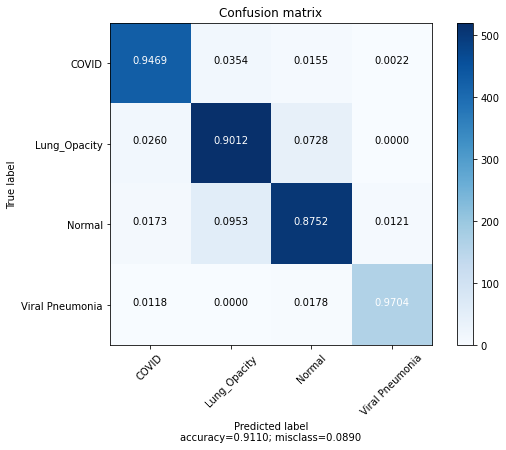

In [24]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm,class_names)